In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
import tensorflow as tf
import scipy.io as sio
from scipy.io import loadmat, savemat
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

2022-02-25 23:59:44.780496: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-02-25 23:59:44.780571: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
fileName = 'random_single source_100snapshots_1000sample'

dataPath = '/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[1]MATLAB/DOA_DATA'


readPath = dataPath +'/' + fileName
print(readPath)

rootPath = '/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[3]Pytorch/[1]DOA_implementation'
savePath = rootPath + '/result'
if not os.path.isdir(savePath):
    os.makedirs(savePath)
print(savePath)

/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[1]MATLAB/DOA_DATA/random_single source_100snapshots_1000sample
/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[3]Pytorch/[1]DOA_implementation/result


In [3]:
# Input train noisy dataset for all snr and stack them together
dataset = tf.data.Dataset.list_files(fileName+'/*/train/train_data.*', shuffle=False)
# for i in dataset.as_numpy_iterator():
#     print(i)
data_set = []
for i in dataset.as_numpy_iterator():
    x_train = sio.loadmat(i)
    x_train = x_train['train_data']  # noisy sample covariance matrix
    data_set.append(x_train[:1000,:]) #NOTE: put all the train_data of different SNR into one list
len(data_set) 

data_train = data_set[0]
for i in data_set:
    data_train = np.vstack((data_train,i)) # stack all the datasets vertically
    
data_train = data_train[1000:] # the first dataset is included in twice
data_train.shape

2022-02-25 23:59:50.906585: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-02-25 23:59:50.945204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 23:59:50.945617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-25 23:59:50.945714: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-02-25 23:59:50.945780: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic l

(41000, 400)

In [4]:
# Input train noiseless dataset for all snr and stack them together
dataset = tf.data.Dataset.list_files(fileName + '/*/train/train_origin_data.*', shuffle=False)
# for i in dataset.as_numpy_iterator():
#     print(i)
data_set = []
for i in dataset.as_numpy_iterator():
    x_train = sio.loadmat(i)
    x_train = x_train['train_origin_data']  # noisy sample covariance matrix
    data_set.append(x_train[:1000,:]) #NOTE: put all the train_data of different SNR into one list
len(data_set) 

data_origin = data_set[0]
for i in data_set:
    data_origin = np.vstack((data_origin,i)) # stack all the datasets vertically
    
data_origin = data_origin[1000:] # the first dataset is included in twice
data_origin.shape

(41000, 400)

In [5]:
# train data shuffle
np.random.seed(2020)
index = np.arange(data_train.shape[0])
print(index)
np.random.shuffle(index)
data_train = data_train[index]
data_origin = data_origin[index]

[    0     1     2 ... 40997 40998 40999]


In [6]:
## scaling
print(data_train.shape)
scaler = MinMaxScaler()
data_train_scale = scaler.fit_transform(np.transpose(data_train))
data_origin_scale = scaler.fit_transform(np.transpose(data_origin))
print(data_train_scale.shape)
print(data_origin_scale.shape)


(41000, 400)
(400, 41000)
(400, 41000)


In [7]:
data_train_scale = np.transpose(data_train_scale)
data_origin_scale = np.transpose(data_origin_scale)
# print(np.max(data_train[0]))
# print(np.max(data_origin[1]))

#### Step 2: Loading the Dataset

In [8]:
# # Transforms images to a PyTorch Tensor
# # transform = transforms.Compose(
# #     [transforms.ToTensor(),
# #     transforms.Normalize((0.5,),(0.5,))]) #NOTE: change the range of the data from 0 to 1 TO -1 to 1.

In [45]:
dataset = []
for i in range(len(data_train)):
    dataset.append((data_train[i],data_origin[i]))

batch_size = 64

# # Create data loaders.
train_dataloader = DataLoader(dataset = dataset, 
                              batch_size = batch_size,
                              shuffle = True)
# test_dataloader = DataLoader(dataset = data_origin, 
#                              batch_size=batch_size,
#                              shuffle = True)

In [46]:
# for X in test_dataloader:
#     print(f"Shape of X [Batch size, Channel, Height, Width]: {X.shape}")
#     # print(f"Shape of y: {y.shape} {y.dtype}")
#     print(f'The maximum value is {torch.max(X)} and minimum value is {torch.min(X)}')
#     break
for X,Y in train_dataloader:
    print(f"Shape of X [Batch size, Channel, Height, Width]: {X.shape}")
    print(f"Shape of Y: {Y.shape} {Y.dtype}")
    print(f'The maximum value is {torch.max(X)} and minimum value is {torch.min(X)}')
    break

Shape of X [Batch size, Channel, Height, Width]: torch.Size([64, 400])
Shape of Y: torch.Size([64, 400]) torch.float64
The maximum value is 131.5105291204092 and minimum value is -24.717898828967616


### Create Autoencoder Class

In [60]:
# Creating a PyTorch class
class AE_dense(torch.nn.Module):
    def __init__(self):
        super(AE_dense,self).__init__()
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 400 ==> 100
        self.encoder = torch.nn.Sequential(
            nn.Linear(400, 300),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            # nn.Linear(100, 50),
            # nn.ReLU()
        )
          
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 100 ==> 400
        self.decoder = torch.nn.Sequential(
            # nn.Linear(50, 100),
            # nn.ReLU(),
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, 300),
            nn.ReLU(),
            nn.Linear(300, 400),
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded,  
    #! NOTE! when calling model(data), it returns a tuple (decoded, encoded). 
    #! Or you can just choose the first value for training.

In [ ]:
class Reshape(nn.Module):
    def __init__(self,shape):
        super(Reshape,self).__init__()
        self.shape = shape
    
    def forward(self, x):
        return x.view(*self.shape) #NOTE: '*' passes multiple parameters(but here with or without * returns the same value)
        

# Creating a PyTorch class
class AE_conv(torch.nn.Module):
    def __init__(self, latent_dim):
        super(AE_conv,self).__init__()
        # Building a convolution encoder with convolutional
        # layer followed by Relu activation function
        # 400 ==> 100
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride = 2, padding=1), # 28 * 28 -> 14 * 14
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride = 2, padding=1), # 14 * 14 -> 7 * 7
            nn.LeakyReLU(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(7*7*64, latent_dim), # second argument: latent_dim
            nn.LeakyReLU()
        )
          
        # Building an convolution decoder with convolutional
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,7*7*64),
            nn.LeakyReLU(),
            Reshape((-1,64,7,7)),
            nn.ConvTranspose2d(64,32,2, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32,1,2, stride=2),
            nn.Tanh())
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded,  
    #! NOTE! when calling model(data), it returns a tuple (decoded, encoded). 
    #! Or you can just choose the first value for training.

### Initializing models

In [61]:
from torchsummary import summary
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

writer = SummaryWriter()

latent_dim = 10

# Model Initialization
model = AE_dense().to(device)
# model = AE_conv(latent_dim).to(device)
  
# Validation using MSE Loss function
loss_fn = torch.nn.MSELoss().to(device)
  
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-2,
                             weight_decay = 1e-8)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,threshold=0.1,patience=1,mode='min')
# summary(model, (1, 28*28))


Using cuda device


### Define training function 

In [62]:
import os 
rootPath = os.getcwd()
# Windoes path
filePath = '/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[3]Pytorch/[1]DOA_implementation'
#  MAC path:
# filePath = '/Users/button/Deeplearning-Autoencoder-DOA/data'
# savePath = filePath + '/result' + '/latent_' + str(latent_dim)
savePath = filePath + '/result' + '/with_normalization'
if not os.path.isdir(savePath):
    os.makedirs(savePath)
print(savePath)

def show(dataloader, model, epoch):
    '''Plot the original and reconstructed images together

    Args:
        dataloader (data_loader): an object that wraps the dataset
        model (model): autoencoder
    '''
    model.eval() #Tell the model you are going to test so the weights will not be updated
    with torch.no_grad():
        for i, X in enumerate(dataloader):
            # X = X.view(X.size(0), -1)
            X = X.type(torch.FloatTensor).to(device) # to is one of the operations(methods) in tensor object

            pred = model(X)
            reconstructed = pred[0]
            
            # plot part
            fig, axs = plt.subplots(2,1, figsize=(20,5)) # 2 means two rows
            # display the original image
            axs[0].plot(X.cpu()) ##Note axs is a matrix, you can't just write axs[], it should be axs[][]
            # display the reconstructed image
            axs[1].plot(reconstructed.cpu())

            plt.savefig(savePath+ f'/epoch-{epoch}.png')
            break
    return fig
            

/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[3]Pytorch/[1]DOA_implementation/result/with_normalization


In [63]:
def train(epochs, dataset,model, loss_fn, optimizer, scheduler):
    size = len(dataset.dataset) # return the number of training samples
    model.train() #Tell the model you are going to train so the weights will be updated
    for t in range(epochs):
        running_loss = 0.0
        print(f"Epoch {t+1}\n-------------------------------")
        for batch, (X,Y) in enumerate(dataset): # iterates the dataloader 
            # X = X.view(X.size(0),-1)
            X = X.type(torch.FloatTensor).to(device)
            Y = Y.type(torch.FloatTensor).to(device)

            # Compute prediction error
            pred = model(X) #! NOTE: Here the returned value is a tuple (decoded, encoded) as defined in forward()
           
            loss = loss_fn(pred[0], Y) # Choose the first value pred[0] as decoded value for the purpose of training
                                        #! NOTE: the second argument should be the original value
            # Backpropagation
            optimizer.zero_grad() # to reset the gradients of model parameters.
            loss.backward() # PyTorch deposits the gradients of the loss w.r.t. each parameter.
            optimizer.step() # to adjust the parameters by the gradients collected in the backward pass.

            # running_loss += loss.item()
            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        ## .. log the running loss
        # writer.add_scalar('training_loss',
        #                     running_loss/1000,
        #                     t)
        # writer.add_figure('predictions vs. actuals',
        #                 show(testdata, model, t, 10),
        #                 global_step=t)
        # for name, param in model.named_parameters():
        #     layer, attr = os.path.splitext(name)
        #     attr = attr[1:]
        #     writer.add_histogram(f'{layer, attr}', param.clone().cpu().data.numpy(),t)
        # scheduler.step(loss)
        # show(testdata, model, t,10)
        # print('Epoch: {}, Loss: {}, LR: {}'.format(t, loss.item(), scheduler.optimizer.state_dict()['param_groups'][0]['lr']))

###  Start training and validating

In [64]:
epochs = 30
train(epochs, train_dataloader, model, loss_fn, optimizer,scheduler)
writer.flush()
print("Done!")

Epoch 1
-------------------------------
loss: 1.386176  [    0/41000]
loss: 0.720962  [ 6400/41000]
loss: 0.534316  [12800/41000]
loss: 0.281899  [19200/41000]
loss: 0.501477  [25600/41000]
loss: 0.467425  [32000/41000]
loss: 0.884466  [38400/41000]
Epoch 2
-------------------------------
loss: 0.405248  [    0/41000]
loss: 0.440428  [ 6400/41000]
loss: 0.576140  [12800/41000]
loss: 0.473552  [19200/41000]
loss: 0.617307  [25600/41000]
loss: 0.588763  [32000/41000]
loss: 0.334362  [38400/41000]
Epoch 3
-------------------------------
loss: 0.922146  [    0/41000]
loss: 0.538046  [ 6400/41000]
loss: 0.468660  [12800/41000]
loss: 0.426014  [19200/41000]
loss: 0.596000  [25600/41000]
loss: 0.495784  [32000/41000]
loss: 0.763974  [38400/41000]
Epoch 4
-------------------------------
loss: 0.886353  [    0/41000]
loss: 0.521579  [ 6400/41000]
loss: 0.549730  [12800/41000]
loss: 0.589003  [19200/41000]
loss: 0.380985  [25600/41000]
loss: 0.241338  [32000/41000]
loss: 0.653301  [38400/41000]


###  Input/Reconstructed Input to/from Autoencoder

In [66]:
# Input test noisy dataset for all snr and stack them together
dataset = tf.data.Dataset.list_files(fileName + '/20dB/test/test_data.*', shuffle=False)
# for i in dataset.as_numpy_iterator():
#     print(i)
data_set = []
for i in dataset.as_numpy_iterator():
    x_train = sio.loadmat(i)
    x_train = x_train['test_data']  # noisy sample covariance matrix
    data_set.append(x_train) #NOTE: put all the train_data of different SNR into one list
len(data_set) 
data_test = data_set[0]
for i in data_set:
    data_test = np.vstack((data_test,i)) # stack all the datasets vertically
data_test = data_test[1000:] # the first dataset is included in twice
print(data_test.shape)
# export data for MATLAB processing
print(savePath)
savePath_ = savePath + '/test_data.mat'
print(savePath_)
savemat(savePath_, {'test_data':data_test})

(1000, 400)
/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[3]Pytorch/[1]DOA_implementation/result/with_normalization
/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[3]Pytorch/[1]DOA_implementation/result/with_normalization/test_data.mat


In [67]:
def reconstructedValue(X, model):
    '''Plot the original and reconstructed images together

    Args:
        X (test data): test dataset
        model (model): autoencoder
    '''
    model.eval() #Tell the model you are going to test so the weights will not be updated
    with torch.no_grad():
        X = torch.from_numpy(X) # change to numpy
        X = X.type(torch.FloatTensor).to(device) # to is one of the operations(methods) in tensor object

        pred = model(X)
        reconstructed = pred[0]
    
    return reconstructed

In [68]:
decoded_data = reconstructedValue(data_test,model)
print(decoded_data.shape)

# Save the denoised data for MATLAB processing
print(savePath)
savePath_ = savePath + '/denoised_data.mat'
print(savePath_)
savemat(savePath_, {'denoised_data':decoded_data})

torch.Size([1000, 400])
/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[3]Pytorch/[1]DOA_implementation/result/with_normalization
/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[3]Pytorch/[1]DOA_implementation/result/with_normalization/denoised_data.mat


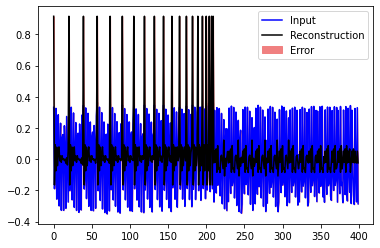

In [71]:
ind = 20
plt.plot(data_test[ind],'b')
plt.plot(decoded_data[ind].cpu(),'k')
plt.fill_between(np.arange(400),decoded_data[ind].cpu(),data_test[ind],color='lightcoral')
plt.legend(["Input", "Reconstruction","Error"])
# plt.savefig('SNR_-30_autoencoder_compare.png')

In [ ]:
# import label
# Input test label dataset for all snr and stack them together
dataset = tf.data.Dataset.list_files(basePath + '/20dB/test/test_label.*', shuffle=False)
# for i in dataset.as_numpy_iterator():
#     print(i)
data_set = []
for i in dataset.as_numpy_iterator():
    x_train = sio.loadmat(i)
    x_train = x_train['test_label']  # noisy sample covariance matrix
    data_set.append(x_train) #NOTE: put all the train_data of different SNR into one list
len(data_set) 
data_label = data_set[0]
for i in data_set:
    data_label = np.vstack((data_label,i)) # stack all the datasets vertically
data_label = data_label[1000:] # the first dataset is included in twice
data_label.shape

print(savePath)
savePath_ = savePath + '\\test_label.mat'
print(savePath_)
savemat(savePath_, {'test_label':data_label})


x_test = sio.loadmat('vec')
test_max = x_test['vec']
test_max = test_max.reshape(1,64)
test_max.shape

encoded_data = autoencoder.encoder(test_max).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()
print(encoded_data.shape)

# Save the denoised data for MATLAB processing
print(savePath)
savePath_ = savePath + '/denoised_data.mat'
print(savePath_)
savemat(savePath_, {'denoised_data':decoded_data})